In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.optimize as sopt
import matplotlib.pyplot as plt
#import pydae.ssa as ssa
#import pydae.grid_tools as gt
import time
import json

In [3]:
from grid_wind_farm import grid_wind_farm_class,run,ini

In [4]:
syst = grid_wind_farm_class()

In [5]:
params = np.array(syst.params_values_list)
u = np.array(syst.u_ini_values_list)
x = syst.struct[0].x
y = syst.struct[0].y_ini
y_ini = syst.struct[0].y_ini
Fx = syst.struct[0].Fx_ini
Fy = syst.struct[0].Fy_ini
Gx = syst.struct[0].Gx_ini
Gy = syst.struct[0].Gy_ini
Fu = syst.struct[0].Fu
Gu = syst.struct[0].Gu
Hx = syst.struct[0].Hx
Hy = syst.struct[0].Hy
Hu = syst.struct[0].Hu
f = syst.struct[0].f
g = syst.struct[0].g

In [6]:
t_0 = time.time()
run(0,syst.struct,3)
print(time.time()-t_0)

110.42569088935852


In [8]:
def set_power(grid_obj,bus_name,power):
    '''
    Set new power to a grid feeder.

    Parameters
    ----------
    grid_obj : object of pydgrid.grid class
    bus_name : string
        name of the grid feeder bus.
    power : complex number
        Complex total power to set for the grid former in VA.

    Returns
    -------
    None.

    '''

    greed_feeders_buses = [item['bus'] for item in grid_obj.grid_feeders]
    gfeed_idx = greed_feeders_buses.index(bus_name)
    grid_obj.params_pf[0].gfeed_powers[gfeed_idx,0] = power/3
    grid_obj.params_pf[0].gfeed_powers[gfeed_idx,1] = power/3
    grid_obj.params_pf[0].gfeed_powers[gfeed_idx,2] = power/3
    

def set_voltage(grid_obj,bus_name,voltage,phase):
    '''
    Set new power to a grid feeder.

    Parameters
    ----------
    grid_obj : object of pydgrid.grid class
    bus_name : string
        name of the grid feeder bus.
    voltage : real escalar
        phase-phase RMS voltage magnitude
    phase : real escalar.
        phase angle in degree.

    Returns
    -------
    None.

    '''

 
    v_a = voltage/np.sqrt(3)*np.exp(1j*np.deg2rad(phase))
    v_b = voltage/np.sqrt(3)*np.exp(1j*np.deg2rad(phase-240))
    v_c = voltage/np.sqrt(3)*np.exp(1j*np.deg2rad(phase-120))
    grid_obj.set_value(f'v_{bus_name}_a_r',v_a.real)
    grid_obj.set_value(f'v_{bus_name}_a_i',v_a.imag)
    grid_obj.set_value(f'v_{bus_name}_b_r',v_b.real)
    grid_obj.set_value(f'v_{bus_name}_b_i',v_b.imag)
    grid_obj.set_value(f'v_{bus_name}_c_r',v_c.real)
    grid_obj.set_value(f'v_{bus_name}_c_i',v_c.imag)
    
    
def get_voltage(grid_obj,bus_name):
    '''
    Get voltage module of a bus.

    Parameters
    ----------
    grid_obj : object of pydae class
    bus_name : string
        name of the bus.

    Returns
    -------
    phase-ground voltage module (V).

    '''
    v_a = syst.get_value(f'v_{bus_name}_a_r') + 1j* syst.get_value(f'v_{bus_name}_a_i')
    U_meas = np.abs(v_a) 
    
    return U_meas

def get_flow(grid_obj,bus_j,bus_k,mode='total',model='pydgrid_pydae'):
    if model == 'pydgrid_pydae':
        v_a   = syst.get_values(f'v_{bus_j}_a_r') + 1j* syst.get_values(f'v_{bus_j}_a_i')
        i_l_a = syst.get_values(f'i_l_{bus_j}_{bus_k}_a_r') + 1j* syst.get_values(f'i_l_{bus_j}_{bus_k}_a_i')
        v_b   = syst.get_values(f'v_{bus_j}_b_r') + 1j* syst.get_values(f'v_{bus_j}_b_i')
        i_l_b = syst.get_values(f'i_l_{bus_j}_{bus_k}_b_r') + 1j* syst.get_values(f'i_l_{bus_j}_{bus_k}_b_i')
        v_c   = syst.get_values(f'v_{bus_j}_c_r') + 1j* syst.get_values(f'v_{bus_j}_c_i')
        i_l_c = syst.get_values(f'i_l_{bus_j}_{bus_k}_c_r') + 1j* syst.get_values(f'i_l_{bus_j}_{bus_k}_c_i')
        s_a = v_a*np.conj(i_l_a)
        s_b = v_b*np.conj(i_l_b)
        s_c = v_c*np.conj(i_l_c)

        if mode == 'total':
            s_t = s_a + s_b + s_c
            return s_t
        if mode == 'abc':
            return s_a,s_b,s_c
  

In [9]:
with open('xy_0_dict.json') as json_file:
    data = json.load(json_file)

for item in data:
    if item in syst.x_list:
        syst.struct[0].x[syst.x_list.index(item)] = data[item]
    if item in syst.y_ini_list:
        syst.struct[0].y_ini[syst.y_ini_list.index(item)] = data[item]     
        
xy_0 = np.vstack([syst.struct[0].x,syst.struct[0].y_ini])[:,0]
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.xy_prev = xy_0
syst.initialization_tol = 1e-6
syst.initialize([{'v_loc_ref_W1lv':1.02,'v_loc_ref_W2lv':1.02,'v_loc_ref_W3lv':1.02,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'K_p_v_W1lv':1,'K_p_v_W2lv':1,'K_p_v_W3lv':1,'K_p_v_STlv':0.0}],xy0='prev')


True

### Local control LV side

In [38]:
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.decimation = 1
syst.update()
syst.xy_prev = xy_0
K_p_v = 0.01
PV_ctrl = 0
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')

p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6

t_0 = time.time()
Dv_r = -0.045
Dq_r = 0.0
events = [
    {'t_end':0.1,
     'Dv_r_W1lv':0,'Dv_r_W2lv':0,'Dv_r_W3lv':0,
     'Dq_r_W1lv':0,'Dq_r_W2lv':0,'Dq_r_W3lv':0,
    },
    {'t_end':0.25,
     'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
     'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r,
    },
          ]
syst.run(events)
print(time.time()-t_0)
syst.post();

0.12965154647827148


<IPython.core.display.Javascript object>


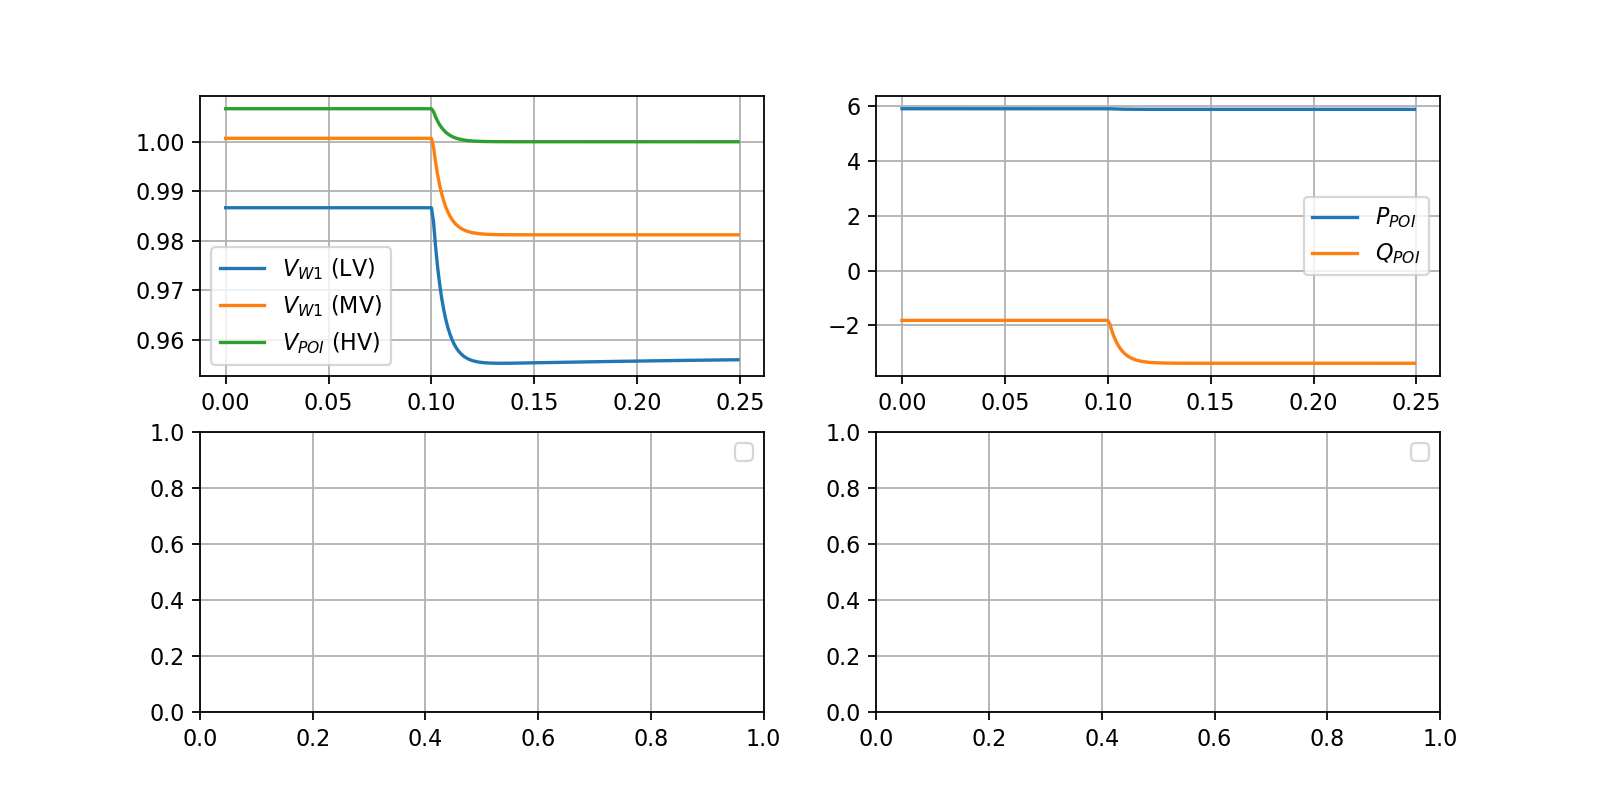

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [50]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 5), frameon=False, dpi=80)

v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label="$V_{W1}$ (LV)")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2lv'), label=f"W2")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3lv'), label=f"W3")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label="$V_{W1}$ (MV)")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2mv'), label=f"W2mv")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3mv'), label=f"W3mv")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$ (HV)")

axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').real/1e6, label="$P_{POI}$")  
axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  
axes[0,0].legend()
fig.savefig('v.svg')

for ax in axes.flatten():
    ax.grid()
    ax.legend()

### Local control MV side

In [42]:
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.decimation = 1
syst.update()
syst.xy_prev = xy_0
K_p_v = 0.04
PV_ctrl = 1
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')

p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6

t_0 = time.time()
Dv_r = -0.02
Dq_r = 0.0
events = [
    {'t_end':0.1,
     'Dv_r_W1lv':0,'Dv_r_W2lv':0,'Dv_r_W3lv':0,
     'Dq_r_W1lv':0,'Dq_r_W2lv':0,'Dq_r_W3lv':0,
    },
    {'t_end':0.25,
     'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
     'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r,
    },
          ]
syst.run(events)
print(time.time()-t_0)
syst.post();

0.10766220092773438


<IPython.core.display.Javascript object>


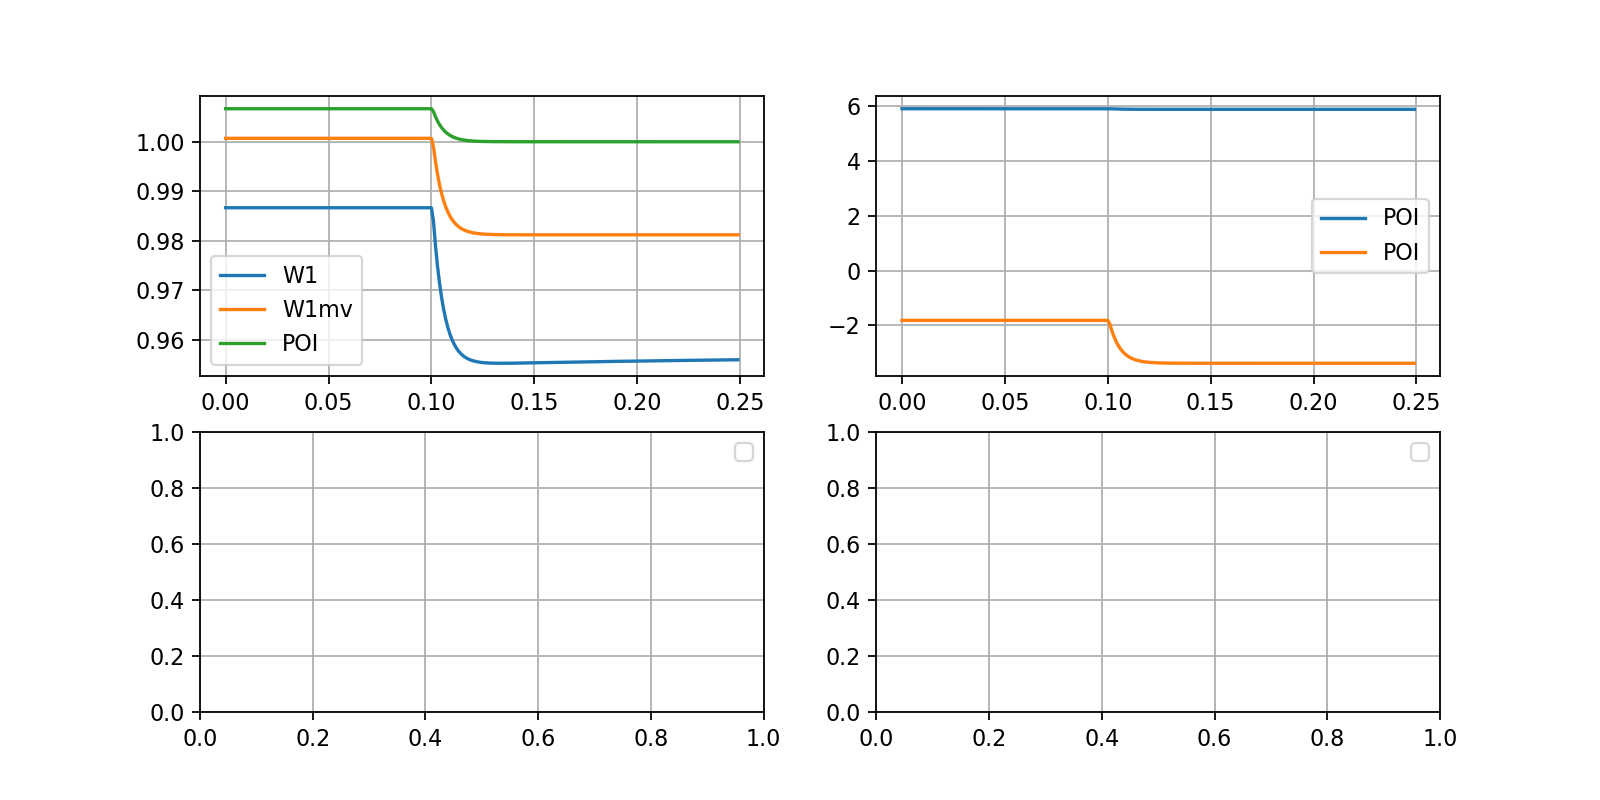

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [43]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 5), frameon=False, dpi=80)

v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label=f"W1")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2lv'), label=f"W2")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3lv'), label=f"W3")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label=f"W1mv")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2mv'), label=f"W2mv")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3mv'), label=f"W3mv")
axes[0,0].plot(syst.T, v_POI_a_m, label=f"POI")


axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').real/1e6, label=f"POI")  
axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label=f"POI")  

fig.savefig('v.svg')

for ax in axes.flatten():
    ax.grid()
    ax.legend()


### Centralized control (local LV)

In [67]:
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.xy_prev = xy_0
syst.initialization_tol = 1e-6
K_p_v = 0.01
PV_ctrl = 0
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')


p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6




Dt = 0.2
Times = np.arange(0,5.0,Dt)
U_ref = 66.0e3
xi = 0

K_p = 0.0001
K_i = 0.25
S_base = 1e6
U_base = 66e3


U = []
Dq_r_list = []

for t in Times:
    
    # perturbations and events
    U_ref_pu = 1.0125
    if t >1.0:
        U_ref_pu = 1.0
    if t >3.0:
        U_ref_pu = 1.0125
    
    U_grid_pu = 1.0
    if t >2.0:
        U_grid_pu = 1.0
    if t >4.0:
        U_grid_pu = 1.0
    
    set_voltage(syst,'GRID',U_grid_pu*66e3,30)
    
    # measurments
    U_meas_pu = get_voltage(syst,'POI')/38105
    
    # PI control
    epsilon = U_ref_pu - U_meas_pu
    xi = xi + Dt*epsilon
    Dq_r = K_p*epsilon + K_i*xi 
    Dv_r = 0.0

    
    events = [{'t_end':t,
               'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
               'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r}]
    syst.run(events)
    
    U += [U_meas_pu]
    Dq_r_list += [Dq_r]
syst.post();    

<IPython.core.display.Javascript object>


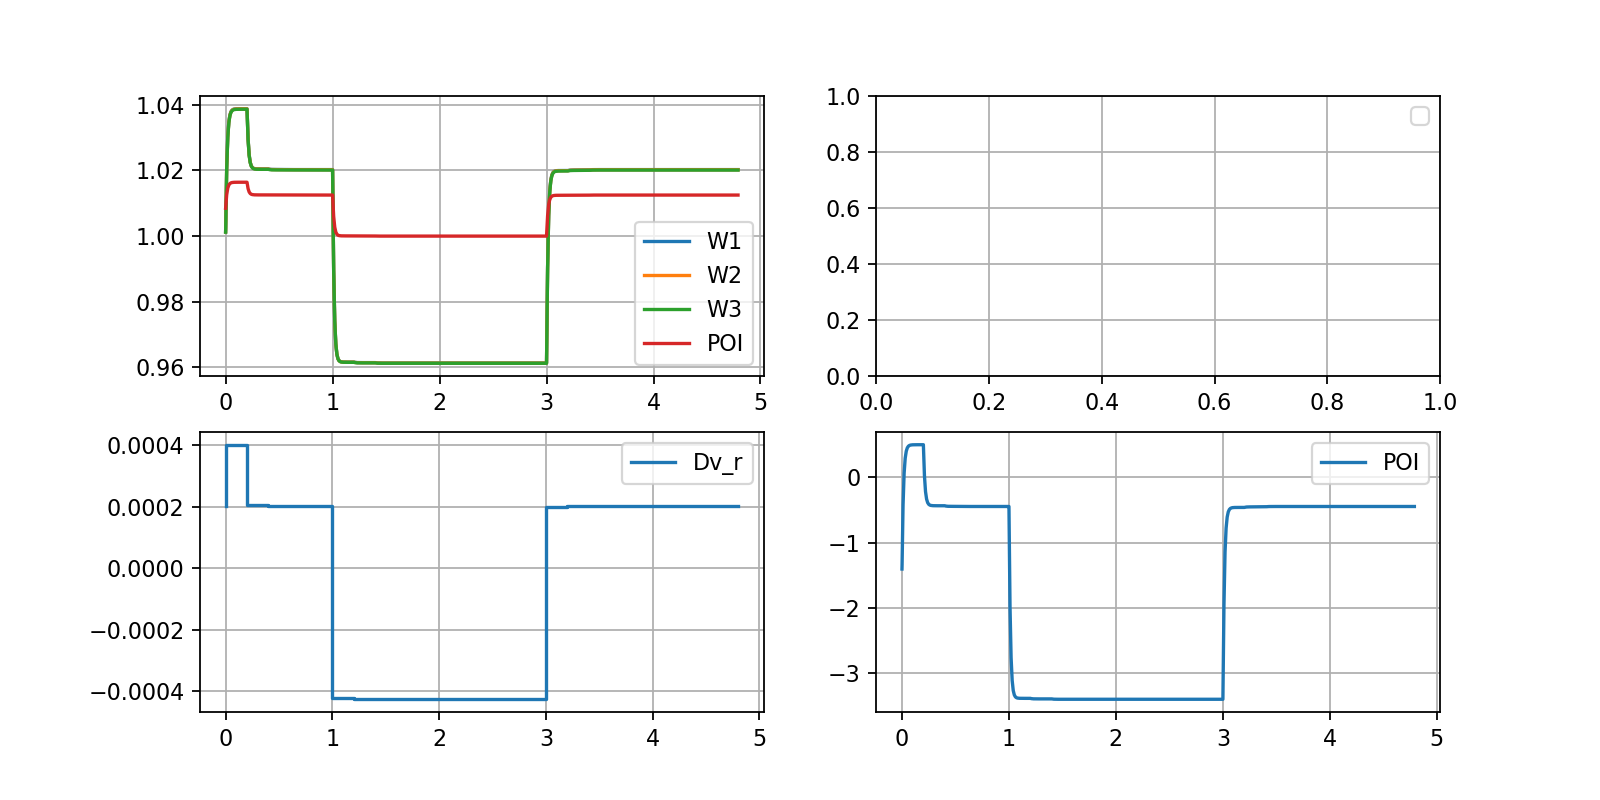

No handles with labels found to put in legend.


In [68]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 5), frameon=False, dpi=80)


v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label=f"W1")
axes[0,0].plot(syst.T, syst.get_values('v_m_W2lv'), label=f"W2")
axes[0,0].plot(syst.T, syst.get_values('v_m_W3lv'), label=f"W3")
axes[0,0].plot(syst.T, v_POI_a_m, label=f"POI")
axes[1,0].step(Times, Dq_r_list, label=f"Dv_r")

axes[1,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label=f"POI")  

for ax in axes.flatten():
    ax.grid()
    ax.legend()


fig.savefig('ctrl_v.svg')

In [67]:
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.xy_prev = xy_0
K_p_v = 0.01
PV_ctrl = 1
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')


p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6




Dt = 0.2
Times = np.arange(0,5.0,Dt)
U_ref = 66.0e3
xi = 0

K_p = 0.001
K_i = 10.0
S_base = 1e6
U_base = 66e3


U = []
Dv_r_list = []

for t in Times:
    
    # perturbations and events
    U_ref_pu = 1.0125
    if t >1.0:
        U_ref_pu = 1.0
    if t >3.0:
        U_ref_pu = 1.0125
    
    U_grid_pu = 1.0
    if t >2.0:
        U_grid_pu = 0.99
    if t >4.0:
        U_grid_pu = 1.0
    
    set_voltage(syst,'GRID',U_grid_pu*66e3,30)
    
    # measurments
    U_meas_pu = get_voltage(syst,'POI')/38105
    
    # PI control
    epsilon = U_ref_pu - U_meas_pu
    xi = xi + Dt*epsilon
    Dv_r = K_p*epsilon + K_i*xi 
    Dq_r = 0.0

    
    events = [{'t_end':t,
               'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
               'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r}]
    syst.run(events)
    
    U += [U_meas_pu]
    Dv_r_list += [Dv_r]
syst.post();    

<IPython.core.display.Javascript object>


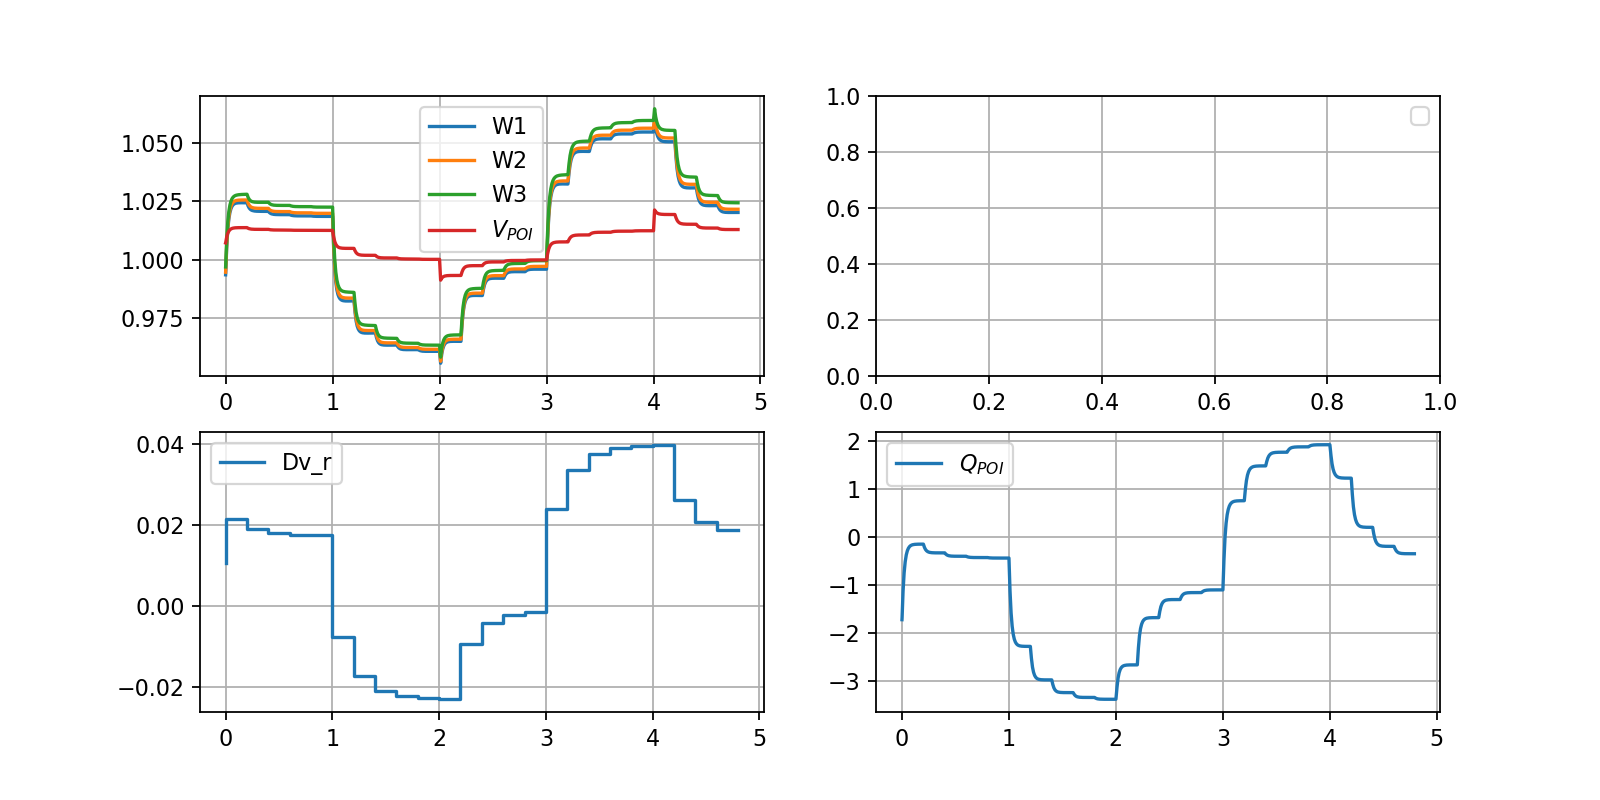

No handles with labels found to put in legend.


In [75]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 5), frameon=False, dpi=80)


v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label=f"W1")
axes[0,0].plot(syst.T, syst.get_values('v_m_W2lv'), label=f"W2")
axes[0,0].plot(syst.T, syst.get_values('v_m_W3lv'), label=f"W3")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$")
axes[1,0].step(Times, Dv_r_list, label=f"Dv_r")

axes[1,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  

for ax in axes.flatten():
    ax.grid()
    ax.legend()

In [ ]:
syst.report_y()

In [ ]:
syst.report_u()